### 머신러닝
- 데이터를 기반으로 학습
- 과거 컴퓨터로 데이터 입력, 특징을 학습 패턴을 찾는 패턴인식

#### 식에 필요한 요소
- 무언가(x)로 무엇(y)를 예측하고 싶다!

    $$ f(x) = y $$

    - x : 독립변수(입력변수), 데이터 문제
    - y : 종속변수(출력변수), 정답
    - f : 머신러닝 모형(모델)

- 우리는 이때까지 f를 직접코딩했음. x값들 입력하면 y가 나오도록 개발
- 머신러닝/딥러닝 x, y를 다 입력해서 훈련을 시켜 함수f를 컴퓨터가 만들도록 하는 것

#### 데이터셋 분리
- 훈련을 시켜서 독립변수에 대한 종속변수가 도출되는 모델 만들 수 있음
- 100% 훈련에 사용하면 검증을 할 데이터 없음
- Train데이터으로 훈련 후 Test데이터로 실험. 또는 Train데이터로 훈련, Valid데이터 검증 후, Test데이터 실험

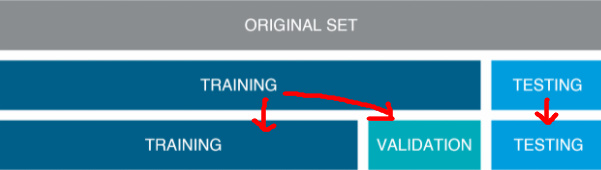

- 100%에서 Train과 Test 나눌때 7:3 또는 8:2 로 비율을 나눔

#### 사이킷런으로 타이타닉 생존자 예측

- 선형회귀 : 선형회귀에 대한 정의는 결론을 본 뒤 설명

- 사이킷런 설치
```python
!pip install scikit-learn
```

In [7]:
# 분석, 시각화 라이브러리 사용/ 없으면 알아서 설치!!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc, font_manager
import warnings
import seaborn as sns
import time
from tqdm import tqdm  # 반복 진행 프로그레스바 모듈

In [86]:
## 영문으로 차트 사용시 설정
warnings.simplefilter('ignore') # 경고메시지 출력숨김

plt.rcParams['font.size'] = 12 # 글자크기
plt.rcParams['figure.figsize'] = (12, 4) # (W, H)
plt.rcParams['axes.grid'] = True # 차트 가로세로줄 표시

## 시본 설정
sns.set_theme(style='darkgrid', color_codes=True)

In [77]:
## Seaborn 팔레트 설정용 함수
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

- https://github.com/datasciencedojo/datasets/blob/master/titanic.csv 에서 통합 데이터 다운로드

In [15]:
## 사이킷런 임포트
from sklearn import preprocessing

##### 데이터 로드

In [17]:
## 타이타닉 훈련데이터
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 데이터 컬럼 정의
    1. PassengerId: 탑승자 데이터 일련번호
    2. Survived: 생존여부 0사망 1생존
    3. Pclass: 티켓의 선실 등급 1일등석실, 2이등석실, 3삼등석실
    4. Name: 탑승자 명
    5. Sex: 성별 male남성, female여성
    6. Age: 나이
    7. SibSp: Sibling(형제), Spouse(배우자) 동반 형제와 배우자수
    8. Parch: Parent, Child 동반한 부모 또는 자녀 인원수
    9. Ticket: 티겟번호
    10. Fare: 티겟요금
    11. Cabin: 선실번호
    12. Embarked: 탑승 항구코드 C.herbourg, Q.ueenstown, S.outhhampton


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 데이터
    - 총 891개, 12개 컬럼, 2개의 float64, 5개 object(=string), 5개 int64

- 결측치(Null값)
    - Age 177개 
    - Cabin 687개
    - Embarked 2개

##### 데이터 전처리
- Age의 결측치 - 나이의 빈값은 평균치 입력
- Cabin의 결측치 - 2등석, 3등석 결측치 분포. 재검토
- Embarked의 결측치 - 탑승항구가 세군데. 그중에 가장 사람들이 많이 탄곳에서 탔을 거다!

In [28]:
# Age의 결측치
## 나이의 평균은 29.6923834 => 30.0
# round(df_train['Age'].mean())
df_train['Age'].fillna(round(df_train['Age'].mean()), inplace=True)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [46]:
# NaN: Not a Number
df_train[df_train['Embarked'].isna()] # 61, 829

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [47]:
## Embarked
## value_counts() 결과는 max부터 내림차순으로 나오기때문에 
# df_train['Embarked'].value_counts().max()
# df_train['Embarked'].value_counts().index[0] # S
df_train['Embarked'].fillna(df_train['Embarked'].value_counts().index[0], inplace=True)

In [55]:
## 해당 인덱스 값만 추출
df_train.loc[[61, 829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


In [57]:
## Cabin 결측치는 컬럼을 삭제
df_train['Cabin'] 

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [ ]:
# axis - 0행삭제, 1열삭제, inplace - 교체여부
df_train.drop(['Cabin'], axis=1, inplace=True)

In [62]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.45,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,Q


##### 차트 시각화

In [64]:
## 성별, 생존자수 파악
df_train.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
['viridis', 'plasma', 'inferno', 'magma', 'cividis']    

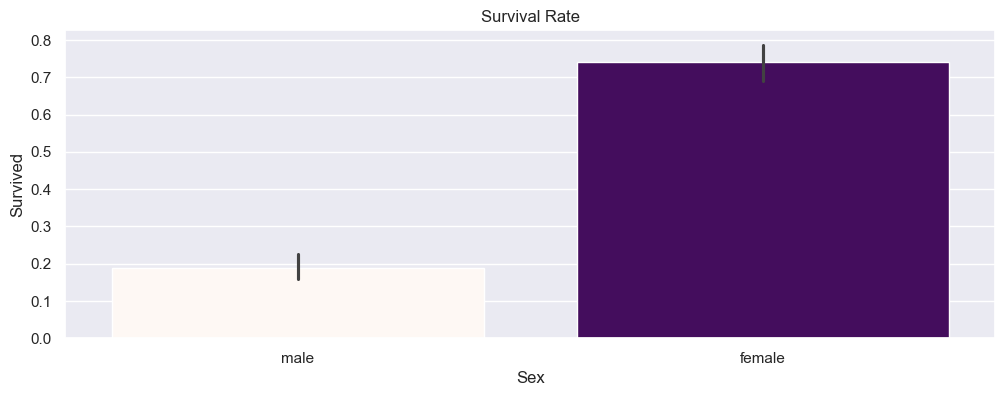

In [87]:
## Seaborn으로 시각화
sns.barplot(data=df_train, x='Sex', y='Survived', palette=colors_from_values(df_train['Survived'], 'RdPu'))
plt.title('Survival Rate')
plt.show()

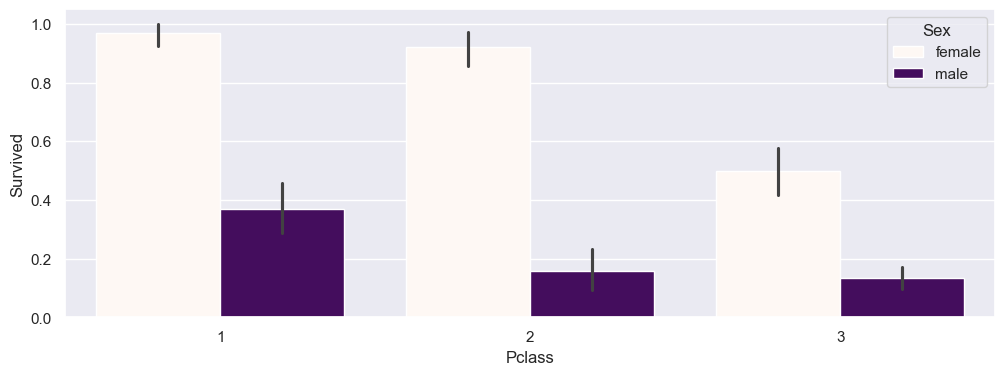

In [88]:
sns.barplot(data=df_train, x='Pclass', y='Survived', hue='Sex', palette=colors_from_values(df_train['Survived'], 'RdPu'))
plt.show()

In [100]:
## 연령대 도출 함수
def get_ageGroup(age):
    cate = ''
    # if age <= -1: cate = 'Unknown'
    if age <= 5: cate = 'Baby'
    elif age <= 12: cate = 'Child'
    elif age <= 18: cate = 'Teenager'
    elif age <= 25: cate = 'Student'
    elif age <= 35: cate = 'Young Adult'
    elif age <= 60: cate = 'Adult'
    else: cate = 'Elderly'

    return cate

In [101]:
group_name = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

In [102]:
df_train['AgeGroup'] = df_train['Age'].apply(lambda x: get_ageGroup(x))

In [103]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,S,Young Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,S,Student
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.45,S,Young Adult
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C,Young Adult
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,Q,Young Adult


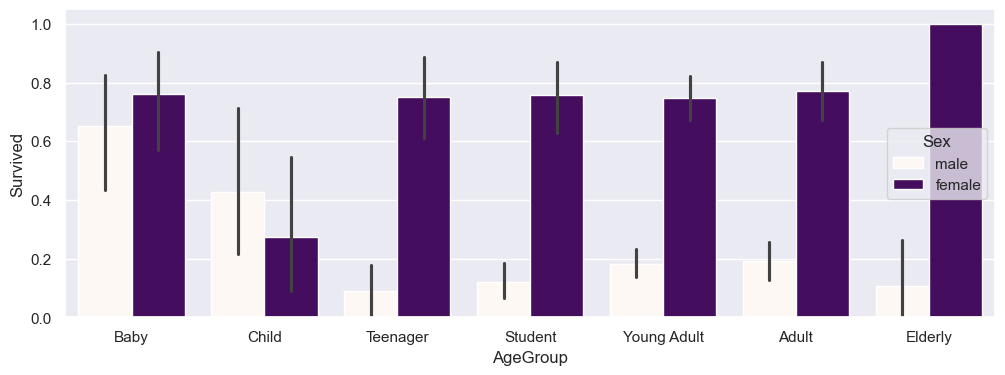

In [104]:
## 연령대로 바차트
sns.barplot(data=df_train, x='AgeGroup', y='Survived', hue='Sex', palette=colors_from_values(df_train['Survived'], 'RdPu'), order=group_name)
plt.show()